In [47]:
import numpy as np
import rasterio
from tensorflow import keras

In [100]:
block_size = 40

In [101]:
dataset = rasterio.open("./data/crs.tiff")
img_data = dataset.read(1)

In [102]:
def load_coords_file(fname: str):
    with open(fname, "r") as f:
        lines = f.readlines()
    return [tuple([float(v) for v in l.strip().split(",")]) for l in lines]

In [103]:
labels = ["no-windmill", "windmill"]
indices = {"no-windmill": 0, "windmill": 1}

wm_x_test = []
wm_y_test = []
wm_x_train = []
wm_y_train = []

for label in labels:
    training_coords = load_coords_file("././training/training_{}.txt".format(label))

    train_n = len(training_coords) / 5 * 4
    i = 0
    for coord in training_coords:
        x, y = dataset.index(coord[0], coord[1])
        img = img_data[x - block_size // 2:x + block_size // 2, y - block_size // 2:y + block_size // 2].astype(
            np.float32)
        img = img / 255
        img = np.expand_dims(img, -1)
        if i < train_n:
            wm_x_train.append(img)
            wm_y_train.append(indices[label])
        else:
            wm_x_test.append(img)
            wm_y_test.append(indices[label])
        i += 1

wm_x_test = np.stack(wm_x_test)
wm_y_test = np.array(wm_y_test)
wm_x_train = np.stack(wm_x_train)
wm_y_train = np.array(wm_y_train)

In [104]:
y_train = keras.utils.to_categorical(wm_y_train, 2)
y_test = keras.utils.to_categorical(wm_y_test, 2)

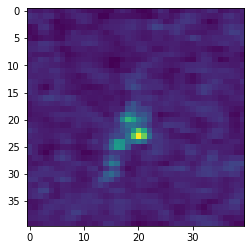

In [105]:
from matplotlib import pyplot as plt

plt.imshow(wm_x_test[17])

In [106]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [107]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [108]:
model.fit(wm_x_train, y_train, epochs=5)

Epoch 1/5
3/3 [==============================] - 1s 25ms/step - loss: 0.6487 - accuracy: 0.6087
Epoch 2/5
3/3 [==============================] - 0s 29ms/step - loss: 0.5817 - accuracy: 0.6522
Epoch 3/5
3/3 [==============================] - 0s 28ms/step - loss: 0.5344 - accuracy: 0.6739
Epoch 4/5
3/3 [==============================] - 0s 21ms/step - loss: 0.5667 - accuracy: 0.7065
Epoch 5/5
3/3 [==============================] - 0s 25ms/step - loss: 0.5047 - accuracy: 0.7391

In [109]:
model.evaluate(wm_x_test, y_test, verbose=2)

1/1 - 0s - loss: 0.4510 - accuracy: 0.6957


[0.4510135352611542, 0.695652186870575]

In [112]:
# model.predict(wm_x_train[:])
from PIL import Image

left_top = (1.85404, 51.93234)
x, y = dataset.index(left_top[0], left_top[1])

for i in range(0, 2000, 10):
    for j in range(0, 2000, 10):
        xx = x + i * block_size
        yy = y + j * block_size
        img = img_data[xx:xx + block_size, yy:yy + block_size]
        img_tf = img.astype(np.float32) / 255
        img_tf = np.expand_dims(img_tf, -1)
        res = model.predict(np.array([img_tf]))
        if res[0][0] < res[0][1]:
            im = Image.fromarray(img.astype('uint8'))
            im.save("./testing/yes/{}_{}.png".format(xx, yy))
        else:
            im = Image.fromarray(img.astype('uint8'))
            im.save("./testing/no/{}_{}.png".format(xx, yy))

In [91]:
dataset.transform * (x + 50 * block_size, y + 50 * block_size)

(1.1321810479782708, 50.81789858663632)